In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
import time

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
try:
  data = pd.read_csv('Structured_features.csv')
except:
  print('No such file')

# encode the erbium concentration float value to int
uniq_concent = data["Erbium Concentration"].unique().tolist()
conc_encoded = {x: i for i, x in enumerate(uniq_concent)}

# for later decode use
encoded_to_conc = {i: x for i, x in enumerate(uniq_concent)}
encoded_to_conc

data["Erbium Concentration"] = data["Erbium Concentration"].map(conc_encoded)
data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance,Erbium Concentration
0,60.505571,20.125896,33.671042,50.346610,0.250792,3.343693,2.390885,17.829646,0
1,61.749309,20.539600,34.363176,51.381524,0.250792,3.412425,2.390885,18.196148,0
2,60.206152,20.026301,33.504417,50.097465,0.250792,3.327146,2.390885,17.741414,0
3,62.014179,20.627703,34.510575,51.601922,0.250792,3.427063,2.390885,18.274199,0
4,62.831822,20.899675,34.965589,52.282281,0.250792,3.472248,2.390885,18.515140,0
...,...,...,...,...,...,...,...,...,...
245,58.273308,19.835527,31.825938,49.270607,0.241979,3.411991,2.493001,17.663388,4
246,57.141365,19.450228,31.207728,48.313539,0.241979,3.345714,2.493001,17.320282,4
247,61.777979,21.028475,33.740012,52.233838,0.241979,3.617195,2.493001,18.725699,4
248,58.251540,19.828118,31.814050,49.252202,0.241979,3.410717,2.493001,17.656790,4


In [3]:
column_name = data.columns[:-1]
df_data = data.copy()
for column in column_name:
    df_data[column] = (df_data[column] - df_data[column].min()) / (df_data[column].max() - df_data[column].min())
    
train_dataset = df_data.sample(frac=0.8, random_state=0)
test_dataset = df_data.drop(train_dataset.index)

# Collect input feature for training, molar volume value in this case
train_features = train_dataset.copy() #dataframe type
test_features = test_dataset.copy()

# Collect respective label, density value in this case
train_labels = train_features.pop('Erbium Concentration') # series type
test_labels = test_features.pop('Erbium Concentration')

In [16]:
from sklearn.linear_model import LogisticRegression

X = np.array(train_features)
y = np.array(train_labels)
test_X = np.array(test_features)
test_y = np.array(test_labels)

logistic_reg = LogisticRegression(
                                  penalty='elasticnet',
                                  solver='saga',
                                  l1_ratio=0.5,
                                  max_iter=200,
                                  )
logistic_reg.fit(X,y)
logistic_reg.score(X,y)

0.405

In [17]:
kfold = KFold(n_splits=5, random_state=7)
result = cross_val_score(logistic_reg, X, y, cv=kfold, scoring='accuracy')
print(result.mean())

0.32999999999999996


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [15]:
parameter_space = {
    'max_iter': [50, 100, 200, 300, 400, 500],
    'l1_ratio': [0.1,0.5,0.9],
}

clf = GridSearchCV(logistic_reg, parameter_space, n_jobs=-1, cv=5)
clf.fit(X, y)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.360 (+/-0.121) for {'l1_ratio': 0.1, 'max_iter': 50}
0.360 (+/-0.121) for {'l1_ratio': 0.1, 'max_iter': 100}
0.360 (+/-0.121) for {'l1_ratio': 0.1, 'max_iter': 200}
0.360 (+/-0.121) for {'l1_ratio': 0.1, 'max_iter': 300}
0.360 (+/-0.121) for {'l1_ratio': 0.1, 'max_iter': 400}
0.360 (+/-0.121) for {'l1_ratio': 0.1, 'max_iter': 500}
0.360 (+/-0.121) for {'l1_ratio': 0.5, 'max_iter': 50}
0.360 (+/-0.121) for {'l1_ratio': 0.5, 'max_iter': 100}
0.360 (+/-0.121) for {'l1_ratio': 0.5, 'max_iter': 200}
0.360 (+/-0.121) for {'l1_ratio': 0.5, 'max_iter': 300}
0.360 (+/-0.121) for {'l1_ratio': 0.5, 'max_iter': 400}
0.360 (+/-0.121) for {'l1_ratio': 0.5, 'max_iter': 500}
0.370 (+/-0.120) for {'l1_ratio': 0.9, 'max_iter': 50}
0.370 (+/-0.120) for {'l1_ratio': 0.9, 'max_iter': 100}
0.370 (+/-0.120) for {'l1_ratio': 0.9, 'max_iter': 200}
0.370 (+/-0.120) for {'l1_ratio': 0.9, 'max_iter': 300}
0.370 (+/-0.120) for {'l1_ratio': 0.9, 'max_iter': 400}
0.370 (+/-0.120) for {'l1_ratio': 0.9, 'max_iter': 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Accuracy : 0.405
Test Accuracy : 0.240
Accuracy score : 0.24


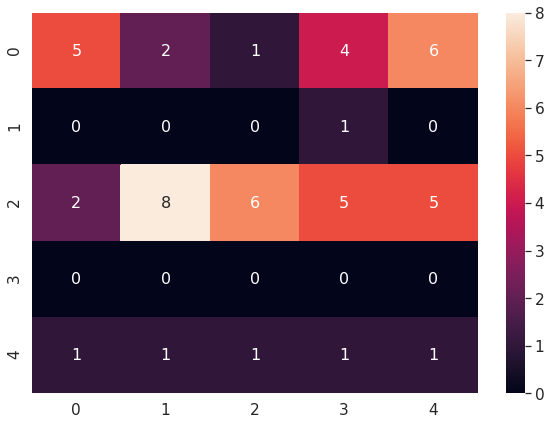

In [20]:
pred_y = logistic_reg.predict(test_X)
train_acc = logistic_reg.score(X, y)
test_acc = logistic_reg.score(test_X, test_y)

print('Training Accuracy : %.3f'%train_acc)
print('Test Accuracy : %.3f'%test_acc)

def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

plt.figure(figsize=(10,7))
cm = confusion_matrix(pred_y, test_y)
print("Accuracy score :", accuracy(cm))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
plt.show()

Training Accuracy : 0.430
Test Accuracy : 0.340
Accuracy score : 0.34


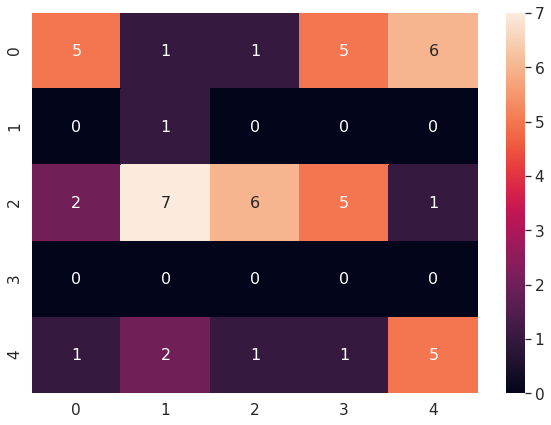

In [23]:
# filtered_df_data = df_data.drop(['Hardness','fractal bond connectivity'], axis=1)
filtered_df_data = df_data[['Longitudinal modulus','Bulk modulus','acoustic impedance','Erbium Concentration']]
filtered_df_data

filtered_train_dataset = filtered_df_data.sample(frac=0.8, random_state=0)
filtered_test_dataset = filtered_df_data.drop(filtered_train_dataset.index)

# Collect input feature for training, molar volume value in this case
filtered_train_features = filtered_train_dataset.copy() #dataframe type
filtered_test_features = filtered_test_dataset.copy()

# Collect respective label, density value in this case
filtered_train_labels = filtered_train_features.pop('Erbium Concentration') # series type
filtered_test_labels = filtered_test_features.pop('Erbium Concentration')

filtered_X = np.array(filtered_train_features)
filtered_y = np.array(filtered_train_labels)
filtered_test_X = np.array(filtered_test_features)
filtered_test_y = np.array(filtered_test_labels)

filter_logistic_reg = LogisticRegression(
                                  penalty='elasticnet',
                                  solver='saga',
                                  l1_ratio=0.5,
                                  max_iter=200,
                                  )
filter_logistic_reg.fit(filtered_X,filtered_y)
filter_logistic_reg.score(filtered_X,filtered_y)

filtered_pred_y = filter_logistic_reg.predict(filtered_test_X)
filtered_train_acc = filter_logistic_reg.score(filtered_X, filtered_y)
filtered_test_acc = filter_logistic_reg.score(filtered_test_X, filtered_test_y)

print('Training Accuracy : %.3f'%filtered_train_acc)
print('Test Accuracy : %.3f'%filtered_test_acc)

plt.figure(figsize=(10,7))
filtered_cm = confusion_matrix(filtered_pred_y, np.array(filtered_test_labels))
print("Accuracy score :", accuracy(filtered_cm))
sns.set(font_scale=1.4)
sns.heatmap(filtered_cm, annot=True, annot_kws={"size": 16})
plt.show()